In [1]:
from functools import partial
from multiprocessing import Pool
from os.path import join
from pathlib import Path
import random

In [2]:
import pandas as pd
import numpy as np
import cv2 as cv
import PIL.Image
from imageio import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
from fastai import defaults
from torch.utils.data import Dataset
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision.transforms.functional import to_tensor, to_pil_image
from fastai.vision import open_image, Image, ImagePoints, FlowField, ImageItemList
from fastai.vision.transform import (
    rotate,
    flip_lr,
    perspective_warp,
    symmetric_warp,
    rand_zoom,
    rand_crop
)

In [4]:
seed = 1
random.seed(seed)
torch.manual_seed(seed)
defaults.device = torch.device('cuda:1')

In [5]:
ROOT = Path.home()/'data'/'landmarks'/'all'
NUM_LANDMARKS = 136

In [6]:
!ls $ROOT

300W  afw  helen  ibug	lfpw


In [7]:
def gather_files(root):
    images = []
    for ext in ('jpeg', 'jpg', 'JPEG', 'JPG', 'png', 'PNG'):
        for filename in root.glob(f'**/*.{ext}'):
            images.append(filename)
    
    points = {}
    for ext in ('pts', 'PTS'):
        for filename in root.glob(f'**/*.{ext}'):
            uid = str(filename.parent / filename.stem)
            points[uid] = filename.relative_to(root)
        
    records = []
    for i, image_file in enumerate(images):
        uid = str(image_file.parent / image_file.stem)
        if uid not in points:
            print(f'Warning: image file {image_file} doesn\'t have landmarks file')
            continue
        rel_path = image_file.relative_to(root)
        records.append({
            'uid': i, 
            'subset': str(rel_path.parts[0]),
            'image': str(rel_path), 
            'points': str(points[uid])})
        
    df = pd.DataFrame(records, columns=['uid', 'subset', 'image', 'points'])
    df.set_index('uid', inplace=True)
    return df

In [8]:
index = gather_files(ROOT)

In [9]:
index.sample(5)

,subset,image,points
uid,,,
2571,afw,afw/310076750_1.jpg,afw/310076750_1.pts
3239,lfpw,lfpw/trainset/image_0560.png,lfpw/trainset/image_0560.pts
3401,lfpw,lfpw/trainset/image_0155.png,lfpw/trainset/image_0155.pts
4259,300W,300W/02_Outdoor/outdoor_278.png,300W/02_Outdoor/outdoor_278.pts
2834,lfpw,lfpw/testset/image_0106.png,lfpw/testset/image_0106.pts


In [10]:
def read_landmarks(filename):
    """Reads file with landmarks information.

    A helper utility to strip the non-relevant content from the .PTS files 
    and read landmarks as two numpy arrays.
    """
    with open(filename, 'r') as file:
        lines = [line.strip() for line in file]

    line = lines[0]
    while not line.startswith('{'):
        line = lines.pop(0)

    xs, ys = [], []
    for line in lines:
        if line.strip().startswith('}'):
            continue
        x, y = line.split()[:2]
        xs.append(x)
        ys.append(y)

    xs = np.array(xs, dtype=np.float) - 1
    ys = np.array(ys, dtype=np.float) - 1
    return xs, ys

In [11]:
class DatasetViewer:
    
    def __init__(self, root, index):
        self.root = root
        self.index = index
    
    def preview_random(self, dataset=None, n=3, **fig_kwargs):
        df = self.index
        if dataset is not None:
            df = self.index[self.index.subset == dataset]
        samples = df.sample(n ** 2)
        if not fig_kwargs:
            fig_kwargs = {'figsize': (10, 10)}
        f, axes = plt.subplots(n, n, **fig_kwargs)
        for (_, record), ax in zip(samples.iterrows(), axes.flat):
            self.preview_image_with_landmarks(record.name, ax=ax)
            ax.set_title(record.name)
    
    def preview_image_with_landmarks(self, uid, ax=None, return_value=False):
        """Shows a single image from traning dataset with landmarks plotted above."""
    
        record = self.index.loc[uid]
        image_path = join(self.root, record.image)
        points_path = join(self.root, record.points)
        img = PIL.Image.open(image_path)
        cmap = 'gray' if len(img.size) == 2 else None
        xs, ys = read_landmarks(points_path)

        if ax is None:
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111)

        ax.scatter(xs, ys, c='darkorange', edgecolor='white', alpha=0.6)
        ax.imshow(img, cmap=cmap)
        ax.set_axis_off()
        
        if return_value:
            return ax   

In [12]:
viewer = DatasetViewer(ROOT, index)

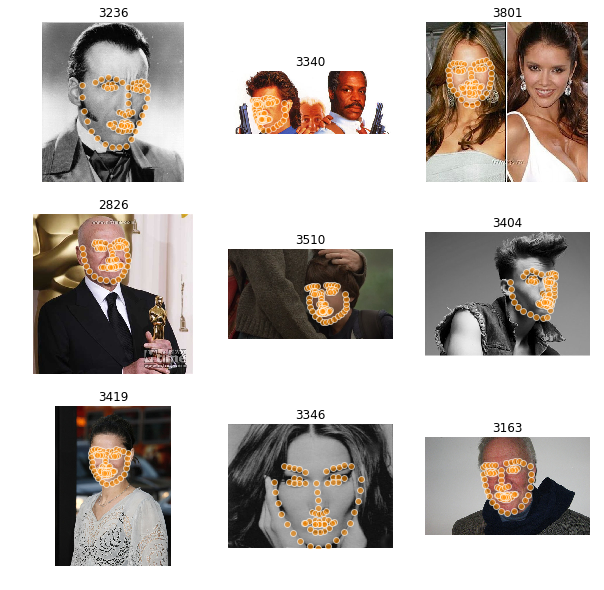

In [13]:
viewer.preview_random('lfpw')

---

In [14]:
def generate_dataset(
    root: str,
    index: pd.DataFrame,
    output: str,
    pad: int=None,
    scale: str='absolute',
    y_first: bool=True
):
    """Converts set of photos with face landmarks into cropped face images 
    and landmarks files.
    
    Args:
        path: Path to the root folder with two subfolders, 'images' and 
            'points', where the raw data files are stored.
            
        index: Data frame with paths to the images and annotations, 
            relative to the 'root' path.
        
        scale: Method how to process landmarks:
            * 'absolute' - keep landmarks in absolute coordinates (i.e., no scaling)
            * 'relative' - scale landmarks into range [0, 1] relatively to the image (w, h)
            * 'center' - scale landmarks into range [-1, 1] relatively to the image's center (w/2, h/2)
            
        y_first: If True then landmarks are saved in format (y, x), otherwise - (x, y)
        
    """
    root = Path(root).expanduser()
    path = Path(output).expanduser()
    
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
        
    (path/'images').mkdir(exist_ok=True)
    (path/'points').mkdir(exist_ok=True)
    files = enumerate(index.to_dict(orient='records'))
    
    parallel(preprocess, files, src=root, dst=path, pad=pad, scale=scale, y_first=y_first)

In [15]:
def parallel(func, args, **params):
    worker = partial(func, **params)
    with Pool() as pool:
        results = pool.map(worker, args)
    return results

In [16]:
def preprocess(x, src, dst, pad, scale, y_first):
    i, record = x
    img = PIL.Image.open(src/record['image'])
    pts = read_landmarks(src/record['points'])
    new_img, (xs, ys) = crop_landmarks(img, pts, pad=pad, scale=scale)
    if y_first:
        landmarks = np.c_[ys, xs]
    else:
        landmarks = np.c_[xs, ys]
    new_img.save(dst/'images'/f'{i}.png', format='PNG')
    np.savetxt(dst/'points'/f'{i}.txt', landmarks, fmt='%.4f', delimiter=',')

In [17]:
def crop_landmarks(pil_image, landmarks, pad=None, scale='asis'):
    if scale not in ('center', 'relative', 'asis'):
        scale = 'asis'
        
    xs, ys = landmarks
    left, right = xs.min(), xs.max()
    top, bottom = ys.min(), ys.max()
    
    if pad is not None:
        left -= pad
        right += pad
        top -= pad
        bottom += pad
        
    cropped = pil_image.crop((left, top, right, bottom))
    xs -= left
    ys -= top
    w, h = (right - left), (bottom - top)
    
    if scale == 'relative':
        xs /= w
        ys /= h
    elif scale == 'center':
        xs = 2*xs/w - 1
        ys = 2*ys/h - 1
    
    return cropped, (xs, ys)

In [18]:
DATA = Path.home()/'data'/'landmarks'/'prepared'

In [19]:
# generate_dataset(ROOT, index, DATA, pad=10, scale='center', y_first=False)

In [20]:
class FaceLandmarks:
    
    def __init__(self, folder, indicies=None, transforms=None):
        folder = Path(folder).expanduser()
        images = read_ordered_files(folder/'images')
        points = read_ordered_files(folder/'points')

        images, points = zip(*[
            (str(x), str(y))
            for i, (x, y) in enumerate(zip(images, points)) 
            if indicies is not None and i in indicies])
        
        self.images = images
        self.points = points
        self.transforms = transforms
    
    def __getitem__(self, item):
        img = imread(self.images[item])
        pts = np.loadtxt(self.points[item], delimiter=',')
        cat = np.r_[pts[:, 0], pts[:, 1]]
        if self.transforms is not None:
            img, cat = self.transforms(img, cat)
        return img, cat
    
    def __len__(self):
        return len(self.images)
    
    def show(self, i, **fig_kwargs):
        img, pts = self[i]
        n = len(pts)
        xs, ys = pts[:n//2], pts[n//2:]
        f, ax = plt.subplots(1, 1, **fig_kwargs)
        width, height = img.size
        xs *= width
        ys *= height
        ax.imshow(img)
        ax.set_axis_off()
        ax.scatter(xs, ys, edgecolor='white', color='darkorange', alpha=0.8)
        
    @property
    def c(self):
        return NUM_LANDMARKS

In [21]:
def read_ordered_files(path):
    return list(sorted([fn for fn in path.iterdir()], key=lambda filename: int(filename.stem)))

In [22]:
n = len(list((DATA/'images').iterdir()))

In [23]:
trn_idx, val_idx = train_test_split(np.arange(n), test_size=0.1)

In [24]:
trn_ds = FaceLandmarks(DATA, indicies=trn_idx)
val_ds = FaceLandmarks(DATA, indicies=val_idx)

## Augmentations

In [25]:
from inspect import signature

In [26]:
def binomial():
    return np.random.rand()

In [27]:
class Resize:
    
    def __init__(self, size):
        self.size = (size, size) if isinstance(size, int) else size
        
    def __call__(self, image):
        return cv.resize(image, self.size, cv.INTER_NEAREST)

In [28]:
class Rotate:
    
    def __init__(self, angle=5):
        self.minmax = (-angle, angle) if isinstance(angle, int) else angle
    
    def __call__(self, image, target=None):
        h, w = image.shape[:2]
        angle = np.random.uniform(*self.minmax)
        m = cv.getRotationMatrix2D((w/2, h/2), angle, 1)
        image = cv.warpAffine(image, m, (w, h))
        
        if target is not None:
            new_target = np.copy(target)
            n = target.shape[0] // 2
            for i in range(n):
                new_target[i] = m[0][0]*target[i] + m[0][1]*target[i + n]
                new_target[i + n] = m[1][0]*target[i] + m[1][1]*target[i + n]
            target = new_target
        
        return image, target

In [29]:
class Shift:
    
    def __init__(self, shift=0.01):
        self.minmax = (shift, shift) if isinstance(shift, float) else shift
    
    def __call__(self, image, target=None):
        h, w = image.shape[:2]
        sx, sy  = self.minmax
        shift_x = np.random.randint(-w*sx, w*sx)
        shift_y = np.random.randint(-h*sy, h*sy)
        m = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        image = cv.warpAffine(image, m, (w, h))
        
        if target is not None:
            new_target = np.copy(target)
            half = target.shape[0] // 2
            last = target.shape[0]
            new_target[0:half] = target[0:half] + shift_x/(w/2)
            new_target[half:last] = target[half:last] + shift_y/(h/2)
            target = new_target
        
        return image, target

In [30]:
def horizontal_flip(image, target=None):
    if target is not None:
        new_target = np.copy(target)
        half = target.shape[0] // 2
        new_target[0:half] *= -1
        target = new_target
    
    return np.fliplr(image), target

In [31]:
class ChangeIllumination:
    
    def __init__(self, min_alpha=0.8, max_alpha=1.1, delta=0.8):
        self.min_alpha = min_alpha
        self.max_alpha = max_alpha
        self.delta = delta
        
    def __call__(self, image, target=None):
        alpha = np.random.uniform(self.min_alpha, self.max_alpha)
        mean = np.mean(image)
        image = self.delta*image + (1 - self.delta)*mean
        image *= alpha
        return image, target

In [32]:
def contiguous(image):
    return np.ascontiguousarray(image)

In [33]:
def expand_channels(image):
    if len(image.shape) == 2:
        image = np.stack((image,)*3, axis=-1)
    return image

In [34]:
def to_xy_tensors(image, target):
    return (
        torch.FloatTensor(image).permute(2, 0, 1),
        torch.FloatTensor(target)
    )

In [35]:
class RandomTargetCompose:
    """Similar to transforms.Compose but optionally passes an additional 
    `target` parameter into transformation callables and applies 
    transformations randomly.
    """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, image, target=None):
        for t in self.transforms:
            if isinstance(t, tuple):
                rand, t = t
                if binomial() > rand:
                    continue
            params = signature(t).parameters
            if 'target' in params:
                image, target = t(image, target)
            else:
                image = t(image)
        return image, target

In [36]:
from torchvision.transforms import RandomAffine

In [37]:
aug = RandomTargetCompose([
    (1.0, Rotate(angle=(-10, 10))),
    (1.0, Shift(shift=0.05)),
    (0.8, ChangeIllumination()),
    (0.5, horizontal_flip),
])

In [38]:
trn_ds = FaceLandmarks(DATA, indicies=trn_idx, transforms=aug)

(75, 77, 3)
(136,)
Range: 0 255


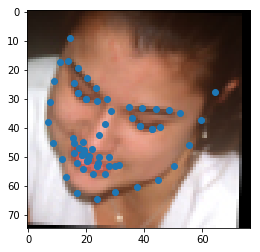

In [39]:
test_img, test_pts = trn_ds[0]
h, w = test_img.shape[:2]
n = len(test_pts)
xs, ys = test_pts[:n//2], test_pts[n//2:]
xs = w*(xs + 1)/2
ys = h*(ys + 1)/2
f, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(test_img.astype('uint8'))
ax.scatter(xs, ys)
print(test_img.shape)
print(test_pts.shape)
print('Range:', test_img.min(), test_img.max())

In [227]:
from fastai import Learner, DatasetType, to_np
from fastai.vision import ImageDataBunch, imagenet_stats, create_cnn
from torchvision import models
from torchvision.transforms.functional import to_tensor

In [41]:
trn_aug = RandomTargetCompose([
    Resize(224),
    (0.5, Rotate(angle=(-10, 10))),
    (0.5, Shift(shift=0.05)),
    (0.5, ChangeIllumination()),
    (0.5, horizontal_flip),
    expand_channels,
    contiguous,
    to_xy_tensors,
    T.Normalize(*imagenet_stats)
])

val_aug = RandomTargetCompose([
    Resize(224),
    expand_channels,
    contiguous,
    to_xy_tensors,
    T.Normalize(*imagenet_stats)
])

trn_ds = FaceLandmarks(DATA, indicies=trn_idx, transforms=trn_aug)
val_ds = FaceLandmarks(DATA, indicies=val_idx, transforms=val_aug)
bunch = ImageDataBunch.create(trn_ds, val_ds, bs=128, num_workers=12)
bunch.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [42]:
# for i in range(len(trn_ds)):
#     print(trn_ds[i][0].size())

In [43]:
# try:
#     for i, x in enumerate(iter(bunch.train_dl)):
#         pass
# except Exception as e:
#     print(e)
#     print('Failed on index %d' % i)

In [44]:
learn = create_cnn(bunch, models.resnet34, loss_func=F.l1_loss)

In [45]:
# learner = Learner(bunch, models.resnet18(), loss_func=F.l1_loss)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


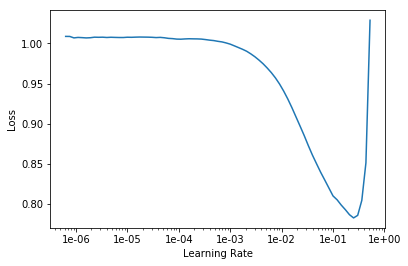

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(10, max_lr=5e-3, wd=1e-2)

epoch,train_loss,valid_loss
1,0.946215,0.568166
2,0.737289,0.322008
3,0.511696,0.249237
4,0.390417,0.410587
5,0.324863,0.228664
6,0.287150,0.208412
7,0.262430,0.200130
8,0.245516,0.201808
9,0.233049,0.193823
10,0.225273,0.193206


In [48]:
from fastai.callbacks import EarlyStoppingCallback

In [49]:
learn.unfreeze()
learn.fit_one_cycle(100, max_lr=1e-5, wd=1e-3, callbacks=[EarlyStoppingCallback(learn, patience=5)])

epoch,train_loss,valid_loss
1,0.215695,0.193969
2,0.215548,0.191995
3,0.215750,0.192496
4,0.215409,0.193205
5,0.215849,0.192272
6,0.214958,0.192028
7,0.215165,0.191870
8,0.214577,0.191579
9,0.214313,0.191246
10,0.212972,0.192561


Epoch 39: early stopping


In [51]:
trn_img, trn_pts = trn_ds[0]

In [52]:
model = learn.model

In [61]:
preds = model(trn_img[None].cuda(1))

In [229]:
preds

tensor([[ 0.6474,  0.5615,  0.5571,  0.4809,  0.4409,  0.2621,  0.0925, -0.0948,
         -0.2535, -0.3655, -0.4358, -0.4995, -0.5644, -0.5677, -0.5770, -0.6347,
         -0.5573,  0.3865,  0.3161,  0.2376,  0.0825, -0.0518, -0.2336, -0.3007,
         -0.4077, -0.5238, -0.5612, -0.1660, -0.1955, -0.2134, -0.2586, -0.0949,
         -0.1721, -0.2471, -0.2818, -0.3537,  0.2877,  0.2122,  0.1017,  0.0296,
          0.1150,  0.2096, -0.2808, -0.3162, -0.4099, -0.4607, -0.4336, -0.3470,
          0.0935, -0.0479, -0.1808, -0.2553, -0.3159, -0.3748, -0.4210, -0.3596,
         -0.3244, -0.2476, -0.1935, -0.0534,  0.0354, -0.1705, -0.2495, -0.2896,
         -0.3827, -0.3027, -0.2376, -0.1770, -0.4756, -0.2809, -0.0750,  0.1403,
          0.3328,  0.5018,  0.6404,  0.7804,  0.8071,  0.7603,  0.6098,  0.4555,
          0.2790,  0.0791, -0.1392, -0.3328, -0.5336, -0.5862, -0.6494, -0.6510,
         -0.6172, -0.5706, -0.5717, -0.6400, -0.6702, -0.7028, -0.6362, -0.4038,
         -0.2564, -0.0983,  

In [233]:
np_img = imread(trn_ds.images[0])

In [231]:
np_pts = to_np(preds.flatten())

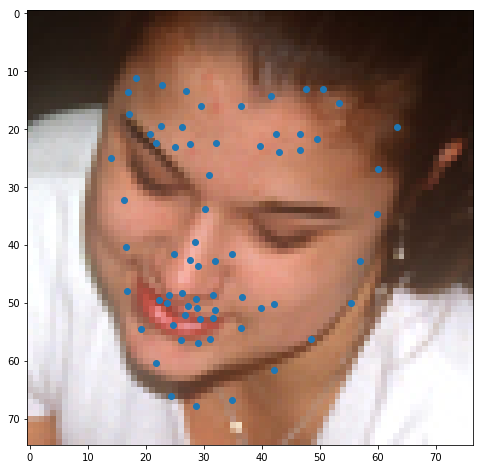

In [238]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
h, w = np_img.shape[:2]
xs, ys = np_pts[:NUM_LANDMARKS//2], np_pts[NUM_LANDMARKS//2:]
xs = w*(xs + 1)/2.
ys = h*(ys + 1)/2.
ax.imshow(np_img)
ax.scatter(xs, ys)